In [1]:
from __future__ import division
from astropy.io import fits
import os,glob,sys
import glob
import copy
import numpy as np
from astropy.table import Table, Column
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import astroscrappy
from astropy.convolution import Gaussian1DKernel, convolve
from scipy import special as sp

In [2]:
# define path
path = '/Users/runquanguan/Documents/136P3/Mix'

In [3]:
os.chdir(path)
filename = glob.glob('*')

## Reduce Function

In [4]:
def get_bias(folder):
    Bias = []
    ARRAY = []
    # pick out bias frame
    for file in folder:
        hdul = fits.open(file)
        TYPE = hdul[0].header['OBJECT']
        if TYPE == 'bias':
            Bias.append(file)
        else:
            pass
            
    # extract data array from data 
    for file in Bias:
        hdul_b = fits.open(file)
        array = hdul_b[0].data
        # form arrays as a list
        ARRAY.append(array[80:2650,100:400])
    # turn list into array again to sum up
    ARRAY = np.array(ARRAY)
    # sum up
    SUM = ARRAY.sum(axis=0)
    # average out
    AVG = SUM/len(ARRAY)
    # return result
    return AVG


def Flat(folder):
    
    L = []
    ARRAY = []
    bias_frame = get_bias(folder)

    for file in folder:
        hdul = fits.open(file)
        header = hdul[0].header
        FRAME = hdul[0].header['OBJECT']  
        if FRAME=='dome_flat':
            L.append(file)
    # Flat = (file-dark-bias)/EXPT
    for file in L:
        hdul = fits.open(file)
        array = hdul[0].data
        ARRAY.append(array[80:2650,100:400])
        
    ARRAY = np.array(ARRAY)
    SUM = ARRAY.sum(axis=0)
    AVG = SUM/len(ARRAY)
    FLAT = AVG - bias_frame
    FLAT = FLAT/np.mean(FLAT)
    return FLAT

In [5]:
def reduce_frame(folder):
    
    L = []
    Reduced = []
    
    # define bias frame
    bias_frame = get_bias(filename)
    Flat_frame = Flat(filename)
    
    # find B science frame
    for file in folder:
        hdul = fits.open(file)
        header = hdul[0].header
        FRAME = hdul[0].header['OBJECT']  
        EXPT = hdul[0].header['EXPTIME']
        if FRAME=='arc':
            L.append(file)
        else:
            pass
             
    for file in L:
        hdul = fits.open(file)
        image_data = hdul[0].data[80:2650,100:400]
        image_header = hdul[0].header
        
        DATA = (image_data - bias_frame) / Flat_frame
        new_file = file[0:5]+"_RDUU"+file[5:9]
        outhdu = fits.PrimaryHDU(data = DATA, header = image_header)
        outhdu.writeto(new_file,overwrite=True)
        
        Reduced.append(new_file)
    return Reduced

In [6]:
stacked_data = fits.getdata('stacked.fits')

In [7]:
spectrum2D = stacked_data
spectrum1D = np.mean(spectrum2D,axis=1)

spectrum1D_list = list(spectrum1D)
list1 = list(spectrum1D)
list1.sort() 

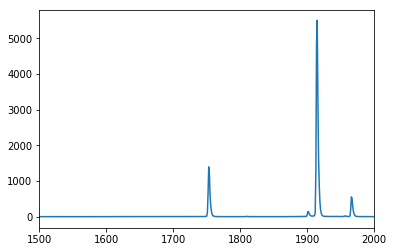

In [8]:
plt.plot(spectrum1D)
plt.xlim(1500,2000)
plt.axvline(x=2253.4,c='r')

In [9]:
# set up calibration points

length = len(list1) 
cali1 = spectrum1D_list.index(list1[length-1])
cali2 = spectrum1D_list.index(list1[length-3])
cali3 = spectrum1D_list.index(list1[length-5])
cali4 = spectrum1D_list.index(list1[length-8])
cali5 = spectrum1D_list.index(list1[length-10])
cali6 = spectrum1D_list.index(list1[length-12])

cali7 = spectrum1D_list.index(list1[length-13])
cali8 = spectrum1D_list.index(list1[length-18])
cali9 = spectrum1D_list.index(list1[length-22])


or1 = 7032.413 #
or2 = 6402.246 #
or3 = 6678.276 #
or4 = 7245.167 #
or5 = 6506.528 #
or6 = 6143.062 #

or7 = 6382.991 #
or8 = 6334.428 # 
or9 = 6929.468 # 

x = np.array([cali1, cali2, cali3, cali4, cali5,
              cali6,cali7, cali8, cali9])
y = np.array([or1, or2, or3, or4, or5,or6,
             or7,or8,or9])
print(x)

[1915  937 1363 2253 1098  535  907  832 1753]


In [10]:
# Linear fit function

def linfit(xdata, ydata, yerror):
    def U(n):
        U_n = sum((xdata**n)/(yerror**2), 0)
        return U_n
    def W(n): 
        W_n = sum(ydata * (xdata**n) / (yerror**2)) 
        return W_n
    D = U(0) * U(2) - (U(1)**2)
    slope = (U(0)*W(1) - U(1)*W(0)) / D
    intercept = (U(2)*W(0) - U(1)*W(1)) / D
    sigma_slope = U(0)/D
    sigma_intercept = U(2)/D
    return slope, intercept

# Fitting slope and intercept

slope = linfit(x,y,1)[0]
inter = linfit(x,y,1)[1]

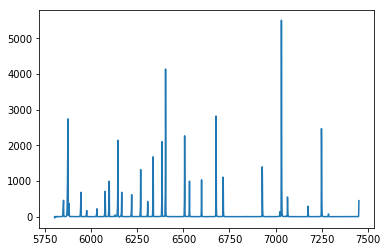

In [11]:
pixel = np.linspace(1,len(spectrum1D),len(spectrum1D))
cali = slope*pixel+inter

# spectrum with lines id

plt.plot(cali,spectrum1D)
plt.show()

y= 0.642814613386485 x+ 5800.269909667825


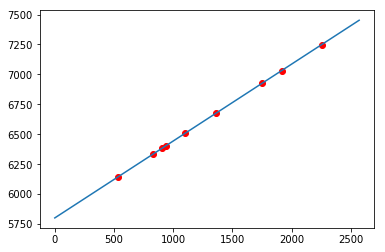

In [12]:
plt.plot(pixel,cali)
plt.scatter(x,y,c='r')
print("y=",slope,"x+",inter)

# IC4202 
### r1169,r1170

In [13]:
# reducing both
def reduce_science(science_folder, cali_folder):
    
    L = science_folder
    Reduced = []
    
    # define bias frame
    bias_frame = get_bias(cali_folder)
    Flat_frame = Flat(cali_folder)
    
    for file in L:
        hdul = fits.open(file)
        image_data = hdul[0].data[80:2650,100:400]
        image_header = hdul[0].header
        
        DATA = (image_data - bias_frame) / Flat_frame
        new_file = file[0:5]+"_RDU"+file[5:10]
        outhdu = fits.PrimaryHDU(data = DATA, header = image_header)
        outhdu.writeto(new_file,overwrite=True)
        
        Reduced.append(new_file)
    return Reduced

In [14]:
IC4202 = ['r1169.fits','r1170.fits']

reduce_science(IC4202,filename)

['r1169_RDU.fits', 'r1170_RDU.fits']

In [15]:

data1 = fits.open('r1169_RDU.fits')[0].data
data2 = fits.open('r1170_RDU.fits')[0].data

new_array = np.zeros(data1.shape)
swaped = np.swapaxes(new_array, 0, 1)

for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        new_array[i,j] = min(data1[i,j],data2[i,j])
        
image_header = fits.open('r1169.fits')[0].header
new_file = "IC4202.fits"
outhdu = fits.PrimaryHDU(data = swaped, header = image_header)
outhdu.writeto(new_file,overwrite=True)


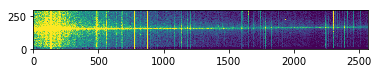

In [16]:
IC_array = fits.open('IC4202.fits')[0].data

a = IC_array
plt.imshow(a, vmin= np.percentile(a, 5), vmax =np.percentile(a, 95), origin='lower')

## Locating center H_alpha line

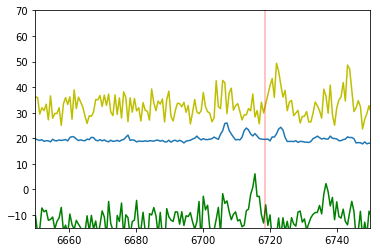

In [17]:
spec2D = IC_array
spec1D = np.mean(spec2D,axis=0)
#spec_a = np.mean(spec2D[130:150],axis=0)
#spec_b = np.mean(spec2D[150:170],axis=0)

spec_a = spec2D[130]
spec_b = spec2D[170]



gauss_kernel = Gaussian1DKernel(3)
spec1D_sm = convolve(spec1D, gauss_kernel)



pixel = np.linspace(1,len(spec1D),len(spec1D))
cali = slope*pixel+inter

plt.plot(cali,spec1D)
plt.plot(cali,spec_a+10,c='y')
plt.plot(cali,spec_b-40,c='g')
plt.xlim(6650,6750)
plt.ylim(-15,70)

z = 0.0237
z_x = 6563*(z+1)
plt.axvline(z_x,c='r',alpha=0.3)

39.299270887949696


1433

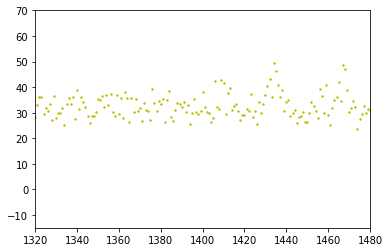

In [18]:
plt.scatter(pixel,spec_a+10,c='y',s=2)
plt.xlim(1320,1480)
plt.ylim(-15,70)
h_alpha = max(spec_a[1330:1530])
print(h_alpha)

list(spec_a).index(h_alpha)

## Extracting Maximum by individual/group

In [19]:

wave_list = []
for i in range(len(spec2D)):
    # 2D-> 1D
    spec_1D = spec2D[i]
    # Smoothening 1D
    gauss_kernel = Gaussian1DKernel(1)
    spec_1D_sm = convolve(spec_1D, gauss_kernel)
    # find value of the brightest pixel
    h_alpha = max(spec_1D_sm[1405:1450])
    # find position of the pixel
    wave_ele = list(spec_1D_sm[1405:1450]).index(h_alpha)
    # create list
    wave_list.append(wave_ele)
    
    
    
trail_wave_list = []
trail_std_list = []
trail_mean_list = []
for i in range(len(spec2D)):
    
    # 2D-> 1D
    spec_1D = spec2D[i]
    
    # Smoothening 1D
    gauss_kernel = Gaussian1DKernel(1)
    spec_1D_sm = convolve(spec_1D, gauss_kernel)
    
    # Truncation 1D to 1405~1450
    spec_1D_trunc = spec_1D_sm[1405:1450]
    
    # Build new list to include the "Sum of each 5 element" as gaussian sum
    sum_spec_1D = []
    for j in range(len(spec_1D_trunc)):
        sum_1D_value = sum(spec_1D_trunc[j-2:j+2])
        sum_spec_1D.append(sum_1D_value)
    
    h_alpha = max(sum_spec_1D)
    
    xp_i = list(sum_spec_1D).index(h_alpha)
    trail_std = np.std(spec_1D_trunc[xp_i-3:xp_i+3])
    trail_mean = np.mean(spec_1D_trunc[xp_i-2:xp_i+2])
    
    trail_wave_list.append(xp_i)
    trail_mean_list.append(trail_mean)
    trail_std_list.append(trail_std)
    


/Users/runquanguan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/runquanguan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<ErrorbarContainer object of 3 artists>

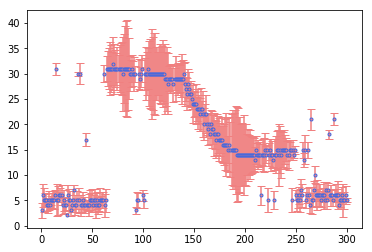

In [20]:
plt.errorbar(np.linspace(1,300,300),trail_wave_list,yerr=trail_std_list,fmt= '.' ,c="lightcoral",mec='royalblue',capsize=4,label="data points")

## Combine radius of two side

In [21]:
# inverse/reverse axis, combines radius


# for x-position:
ICWL_m = np.mean(trail_wave_list[70:240])

# center at 161
ICWL_1 = trail_wave_list[50:161]
ICWL_2 = trail_wave_list[161:272]

ICWL_1G = list(np.flip(ICWL_1))
ICWL_2G = []

for i in ICWL_2:
    new_i = 2*ICWL_m-i
    ICWL_2G.append(new_i)
    
ICWL = [None]*(len(ICWL_1G)+len(ICWL_2G))
ICWL[::2] = ICWL_1G
ICWL[1::2] = ICWL_2G



# for STD:
ICWL_std_m = np.mean(trail_std_list[70:240])

ICWL_std_1 = trail_std_list[50:161]
ICWL_std_2 = trail_std_list[161:272]

ICWL_std = [None]*(len(ICWL_std_1)+len(ICWL_std_2))
ICWL_std[::2] = ICWL_std_1
ICWL_std[1::2] = ICWL_std_2

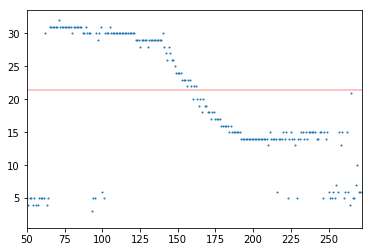

In [22]:
pixel = np.linspace(1,300,300)
plt.scatter(pixel,trail_wave_list,s=1)
plt.xlim(50,272)
#plt.ylim(10,35)
plt.axhline(21.470,c='r',alpha=0.3)

## Eliminate Outlier

In [23]:
def reject_outlier(L,n=3):
    new_list = []
    for i in range(len(L)):
        if np.std(L[i-1:i+1])>=n:
            j = sum(L[i+1:i-1])/2
            new_list.append(j)
        else:
            new_list.append(L[i])
    return new_list

def zero_elm(L):
    new_list = []
    for i in range(len(L)):
        if L[i] == 0:
            j = np.mean(L)
            new_list.append(j)
        else:
            new_list.append(L[i])
    return new_list
            
        
ICWL = reject_outlier(ICWL)

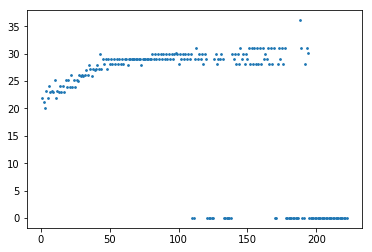

In [24]:
len(ICWL)
plt.scatter(np.linspace(1,222,222),ICWL,s=3)
#plt.xlim(169,200)
#plt.ylim(-1,1)

## Dividing 5x5 bins

In [25]:
# Yield successive n-sized 
# chunks from l. 
def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
#divide the list into chunks of 10 elements
#caculate the mean and std


def extract_error(L):
    d = 0
    for i in L:
        sq_i = i**2
        d = d+sq_i
    return np.sqrt(d)/len(L)

def extract_data(L):
    d = 0
    for i in L:
        d = d+i
    return d/np.count_nonzero(L)

def extract_data_G(L):
    J = []
    for i in L:
        if i != 0:
            J.append(i)
        else:
            pass
    return np.median(J)
        



ICWL_div = np.array(list(divide_chunks(ICWL[0:169], 10)) )
ICWL_std_div = np.array(list(divide_chunks(ICWL_std[0:169], 10)) )


# find mean and error
ICdata = []
ICerr = []
IC_trail = []

for i in range(len(ICWL_div)):
    new_data = extract_data(ICWL_div[i])
    ICdata.append(new_data)
    
for i in range(len(ICWL_div)):
    new_data = extract_data_G(ICWL_div[i])
    IC_trail.append(new_data)

for i in range(len(ICWL_std_div)):
    new_error = extract_error(ICWL_std_div[i])
    ICerr.append(new_error)

ICwave = []
ICvelocity = []
ICverr = []

for i in ICdata:
    obs = (i+1480)*slope+inter
    z = (obs-6562.8)/6562.8
    v = z*299792.458
    ICwave.append(obs)
    ICvelocity.append(v)

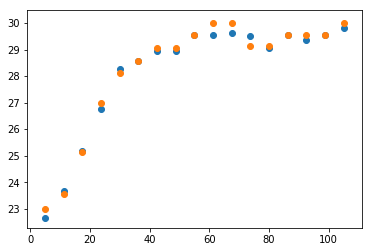

In [27]:
# median vs. mean
new_pixel = np.linspace(5,105,len(ICdata))
plt.scatter(new_pixel,ICdata)
plt.scatter(new_pixel,IC_trail)

<ErrorbarContainer object of 3 artists>

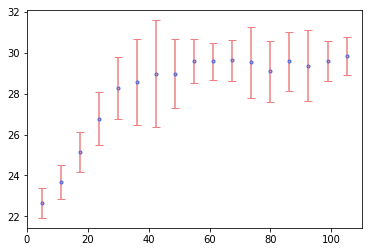

In [28]:
new_pixel = np.linspace(5,105,len(ICdata))
plt.errorbar(new_pixel,ICdata,yerr=ICerr,fmt= '.' ,c="lightcoral",mec='royalblue',capsize=4,label="data points")

In [29]:
#0.43*arcsec
#110.66*Mpc

pix2kpc = np.deg2rad(0.43/3600)*110660

radius = []
velocity = []
velocity_error = []

for i in new_pixel:
    new_i = i*pix2kpc
    radius.append(new_i)
    

for i in ICdata:
    obs = (i+1405+161)*slope+inter
    z = (obs-6562.8)/6562.8
    v = (z-0.0238)*299792.458-4650+70
    velocity.append(v)

for i in ICerr:
    new_i = i*299792.458*0.64281/6562.8
    velocity_error.append(new_i)

## IC4204 Velocity Dispersion Model

In [30]:
def V_SQ_R(R):
    G = 4.302e-6 #m3 kg-1 s-2
    
    m_stellar = 180e9 #solar mass
    Rd = 4.86 #kpc
    sigma_0 = m_stellar/(2*np.pi*Rd**2)
    y = R/(2*Rd)
    
    I0 = sp.iv(0,y)
    I1 = sp.iv(1,y)
    
    K0 = sp.kv(0,y)
    K1 = sp.kv(1,y)

    V2 = 4*np.pi*G*sigma_0*Rd*(y**2)*(I0*K0-I1*K1)
    v = np.sqrt(V2)
    return v

model_v = []
r_max = 25
for i in np.linspace(0,r_max,100):
    modelv = V_SQ_R(i)
    model_v.append(modelv)

/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


<ErrorbarContainer object of 3 artists>

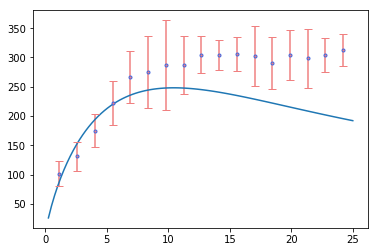

In [31]:
   
# now model_v is the set of model velocity

plt.plot(np.linspace(0,r_max,100),model_v)
plt.errorbar(radius,velocity,yerr=velocity_error,fmt= '.' ,c="lightcoral",mec='royalblue',capsize=4,label="data points")

In [32]:
radius,velocity,velocity_error
dis_v_list = []
for i in radius:
    dis_model_v = V_SQ_R(i)
    dis_v_list.append(dis_model_v)
    

In [33]:
len(velocity_error)

17

In [34]:
IC_table = Table([
    Column(data = np.array(radius),name = 'IC_r',dtype = float),
    Column(data = np.array(velocity),name = 'IC_v',dtype = float),
    Column(data = np.array(velocity_error),name = 'IC_err',dtype = float)
])


IC_table.write('IC_table.csv', format='csv',overwrite=True)

Model_table = Table([
    Column(data = np.array(np.linspace(0,r_max,100)),name = 'model_r',dtype = float),
    Column(data = np.array(model_v), name = 'model_v',dtype = float),
])

Model_table.write('Model_table.csv', format='csv',overwrite=True)

# UGC7321 
### r1171, 73, 74, 75

In [35]:
UGC7321 = ['r1171.fits','r1173.fits','r1174.fits','r1175.fits']

reduce_science(UGC7321,filename)

['r1171_RDU.fits', 'r1173_RDU.fits', 'r1174_RDU.fits', 'r1175_RDU.fits']

In [36]:
# Clean Cosmic Rays

data1 = fits.open('r1171_RDU.fits')[0].data
data2 = fits.open('r1173_RDU.fits')[0].data
data3 = fits.open('r1174_RDU.fits')[0].data
data4 = fits.open('r1175_RDU.fits')[0].data

# Create a array of all zero
new_array = np.zeros(data1.shape)
swaped = np.swapaxes(new_array, 0, 1)


for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        a = data1[i,j]
        b = data2[i,j]
        c = data3[i,j]
        d = data4[i,j]
        new_array[i,j] = (sum([a,b,c,d])-max(a,b,c,d))/3
        
image_header = fits.open('r1171.fits')[0].header
new_file = "UGC7321.fits"
outhdu = fits.PrimaryHDU(data = swaped, header = image_header)
outhdu.writeto(new_file,overwrite=True)



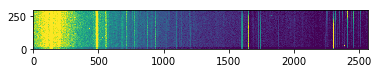

In [37]:
UGC_array = fits.open('UGC7321.fits')[0].data

a = UGC_array
plt.imshow(a, vmin= np.percentile(a, 5), vmax =np.percentile(a, 95), origin='lower')

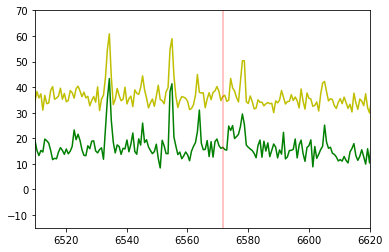

In [38]:
UGC_spec2D = UGC_array
UGC_spec1D = np.mean(spec2D,axis=0)
#spec_a = np.mean(spec2D[130:150],axis=0)
#spec_b = np.mean(spec2D[150:170],axis=0)

UGC_spec_a = UGC_spec2D[30]
UGC_spec_b = UGC_spec2D[150]



gauss_kernel = Gaussian1DKernel(3)
UGC_spec1D_sm = convolve(UGC_spec1D, gauss_kernel)



pixel = np.linspace(1,len(UGC_spec1D),len(UGC_spec1D))
cali = slope*pixel+inter

plt.plot(cali,UGC_spec_a+10,c='y')
plt.plot(cali,UGC_spec_b-10,c='g')
plt.xlim(6510,6620)
plt.ylim(-15,70)

z = 0.00136
z_x = 6562.8*(z+1)
plt.axvline(z_x,c='r',alpha=0.3)